In [4]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt 
import seaborn as sns
from matplotlib import rcParams
import os
import glob
from scipy.signal import find_peaks, peak_prominences, peak_widths
import copy

In [32]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, 0]
event_type = 'RNP_'
het_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\HET/*" # path to het folder remember /*
wt_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\WT/*"
def read_files(path): 
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    #ts1 = ts2 since iso and dopamine are recorded simulteanosuly (I can't spell)
    
    zerror = np.std(zall, axis=0)

    return zall, ts1, ts2, zerror



In [33]:
h_dict = {}
w_dict = {}

for file in glob.glob(het_path):
    z_ind = read_files(file)
    h_ts1 = z_ind[1]
    ts2 = z_ind[2]
    h_dict[os.path.basename(file)]={"z-score": z_ind[0]}
for file in glob.glob(wt_path):
    z_ind = read_files(file)
    w_ts1 = z_ind[1]
    w_dict[os.path.basename(file)]={"z-score": z_ind[0]}

read from t=0s to t=1798.97s
read from t=0s to t=1798.4s
read from t=0s to t=1798.54s
read from t=0s to t=1799.2s
read from t=0s to t=1799.09s
read from t=0s to t=1799.1s


In [241]:
trimmed_ts = []
trimmed_idx = []
timeend = 2.5
timestart = 0
for i in range(len(ts2)):
    if ts2[i]>timestart and ts2[i]<timeend:
        trimmed_ts.append(ts2[i])
        trimmed_idx.append(i)
for key in h_dict.keys():
    trimmed_z_key = []    
    for i in range(len(h_dict[key]['z-score'])):
        trimmed_z = []
        for j in range(len(h_dict[key]['z-score'][i])):
            if j in trimmed_idx:
                trimmed_z.append(h_dict[key]['z-score'][i][j])
        trimmed_z_key.append(trimmed_z)
    h_dict[key]['trimmed_z-score']=trimmed_z_key

for key in w_dict.keys():
    trimmed_z_key = []    
    for i in range(len(w_dict[key]['z-score'])):
        trimmed_z = []
        for j in range(len(w_dict[key]['z-score'][i])):
            if j in trimmed_idx:
                trimmed_z.append(w_dict[key]['z-score'][i][j])
        trimmed_z_key.append(trimmed_z)
    w_dict[key]['trimmed_z-score']=trimmed_z_key

In [283]:
def biexponential(t, A1, k1, A2, k2, b):
    return (A1 * np.exp(-k1 * t)) + (A2 * np.exp(-k2 * t)) + b


def biexponential2(t, I0, Imax, T0, k1, k2):
    y = I0 + (Imax * (1 - np.exp(-((t - T0) / k1))) * np.exp(-((t - T0) / k2)))
    y[t <= T0] = I0
    return y

def Gamma(t, A, alpha, beta, Y0, T0):
    y = Y0 + (A * ((t - T0)**alpha) * np.exp(-(t-T0)/beta)) 
    y[t<=T0] = Y0
    return y

def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))
_1gaussian_init = [3, .75, .5]

In [258]:
y = np.array(np.mean(h_dict['RI4_EN114_010124-240501-150749']['trimmed_z-score'], axis = 0))
t = np.array(trimmed_ts)

In [284]:
# initial_guess = [t,5,1]
# y_scaled = y / np.max(y)
# bounds = ([2000, 0, 0, 0], [10000, np.inf, np.inf, np.inf])/
# weights = 1.0 / np.sqrt(y)
Gamma_init = [1, 1, 1, 1, 0]
params, covariance = curve_fit(Gamma, t, y, p0=Gamma_init, maxfev = 100000)


#amp, cent, sigma = params
print(f"Fitted Parameters - A, alpha, beta, y0, t0:", *params)

Fitted Parameters - A, alpha, beta, y0, t0: 66.4301024818333 1.6160875059409108 0.2820991007213714 -0.4366358230776221 0.28668948116839893


C:\Users\User\AppData\Local\Temp\ipykernel_33284\1380336243.py:11: RuntimeWarning: invalid value encountered in power
  y = Y0 + (A * ((t - T0)**alpha) * np.exp(-(t-T0)/beta))


C:\Users\User\AppData\Local\Temp\ipykernel_33284\1380336243.py:11: RuntimeWarning: invalid value encountered in power
  y = Y0 + (A * ((t - T0)**alpha) * np.exp(-(t-T0)/beta))
C:\Users\User\AppData\Local\Temp\ipykernel_33284\2968556191.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


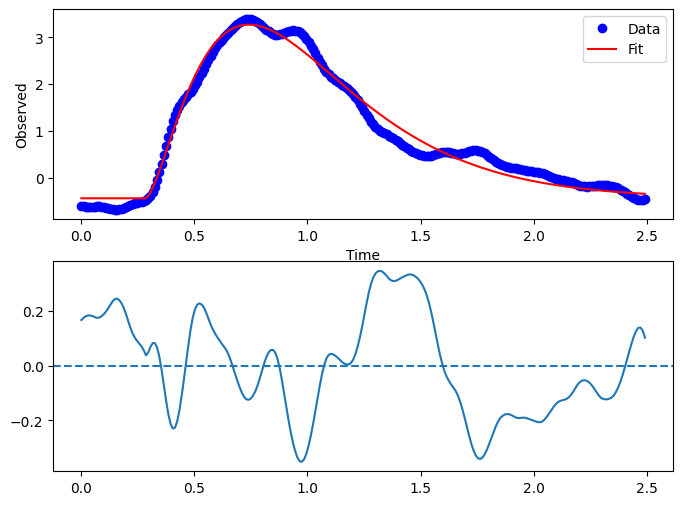

In [285]:

fitted_y = Gamma(t, *params)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].plot(t, y, 'bo', label='Data')
axs[0].plot(t, fitted_y, 'r-', label='Fit')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Observed')
axs[0].legend()

axs[1].plot(t, fitted_y-y)
axs[1].axhline(0, ls='--')
fig.show()
